In [ ]:
from google.colab import files
files.upload()

KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
!mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d taejoongyoon/mitbit-arrhythmia-database

Dataset URL: https://www.kaggle.com/datasets/taejoongyoon/mitbit-arrhythmia-database
License(s): CC0-1.0
 98% 283M/288M [00:06<00:00, 43.0MB/s]
100% 288M/288M [00:06<00:00, 44.3MB/s]


In [ ]:
!unzip mitbit-arrhythmia-database

Archive:  mitbit-arrhythmia-database.zip
  inflating: mitbih_database/100.csv  
  inflating: mitbih_database/100annotations.txt  
  inflating: mitbih_database/101.csv  
  inflating: mitbih_database/101annotations.txt  
  inflating: mitbih_database/102.csv  
  inflating: mitbih_database/102annotations.txt  
  inflating: mitbih_database/103.csv  
  inflating: mitbih_database/103annotations.txt  
  inflating: mitbih_database/104.csv  
  inflating: mitbih_database/104annotations.txt  
  inflating: mitbih_database/105.csv  
  inflating: mitbih_database/105annotations.txt  
  inflating: mitbih_database/106.csv  
  inflating: mitbih_database/106annotations.txt  
  inflating: mitbih_database/107.csv  
  inflating: mitbih_database/107annotations.txt  
  inflating: mitbih_database/108.csv  
  inflating: mitbih_database/108annotations.txt  
  inflating: mitbih_database/109.csv  
  inflating: mitbih_database/109annotations.txt  
  inflating: mitbih_database/111.csv  
  inflating: mitbih_database/1

In [ ]:
!pip install keras

In [ ]:
# libraries
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import itertools
import collections

%matplotlib inline


In [ ]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True


In [ ]:
def get_train_inputs():
    x = tf.constant(X_train)
    y = tf.constant(y_train)
    return x, y

# Test Inputs
def get_test_inputs():
    x = tf.constant(X_test)
    y = tf.constant(y_test)
    return x, y

# Eval data
def get_eval_data():
    return tf.constant(X_test)

# Plot matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        #cm[i, j] = 0 if np.isnan(cm[i, j]) else cm[i, j]
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [ ]:
path = '/content/mitbih_database/mitbih_database/'
window_size = 160
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V', '/']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()


In [ ]:
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt
records = list()
annotations = list()
filenames.sort()


In [ ]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)

    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)


<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-13-567776b5294f>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:


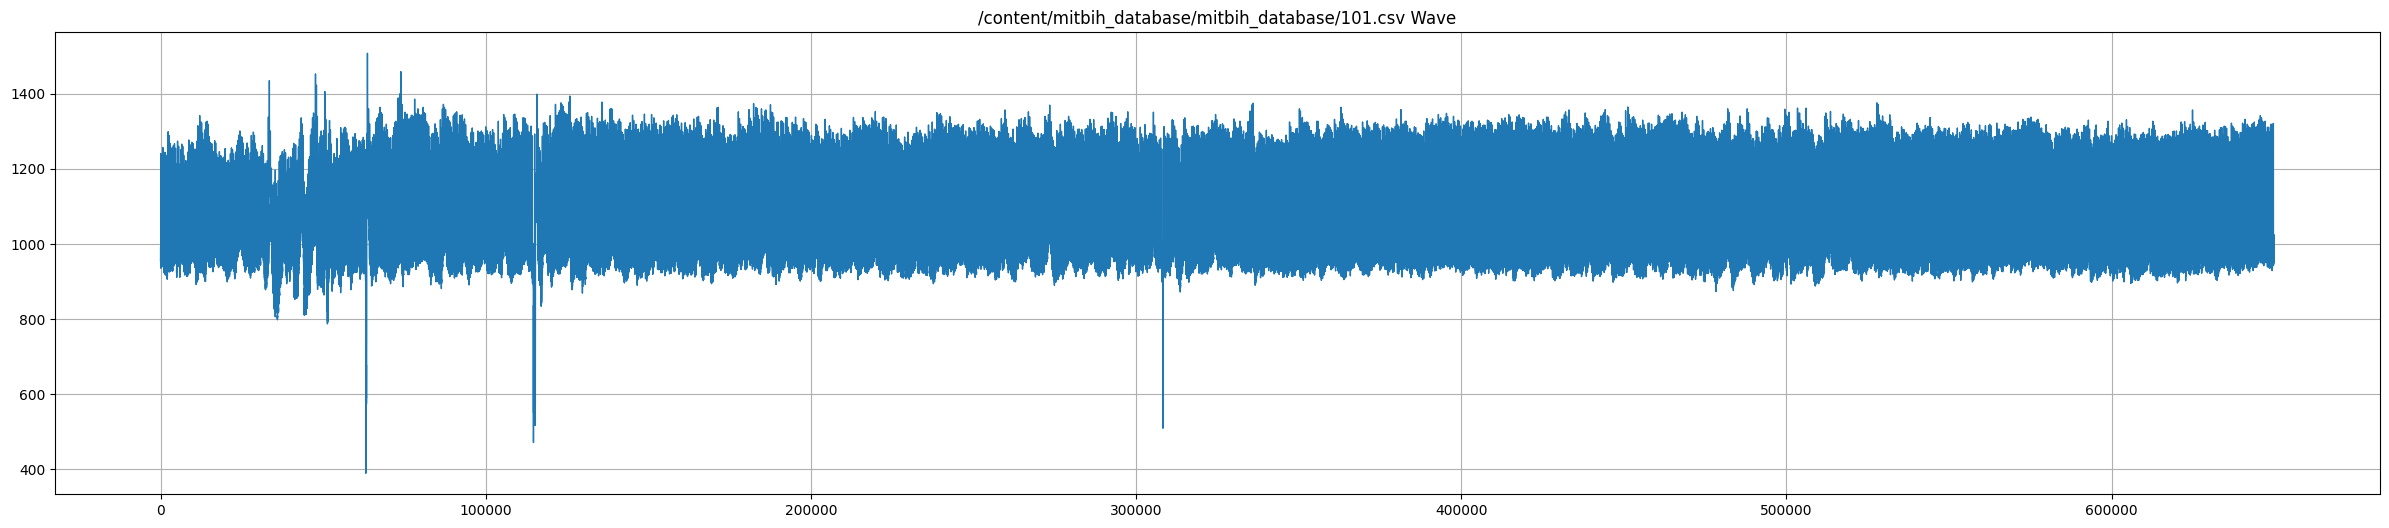

In [ ]:
# Records
for r in range(0,len(records)):
# for r in range(2, 3):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1

    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals)
        plt.show()

    # Read anotations: R position and Arrhythmia class
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines()
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
                    pass
                else:
                    count_classes[arrhythmia_index] += 1
                    if(window_size < pos and pos < (len(signals) - window_size)):
                        beat = signals[pos-window_size+1:pos+window_size]
                        X.append(beat)
                        y.append(arrhythmia_index)


0


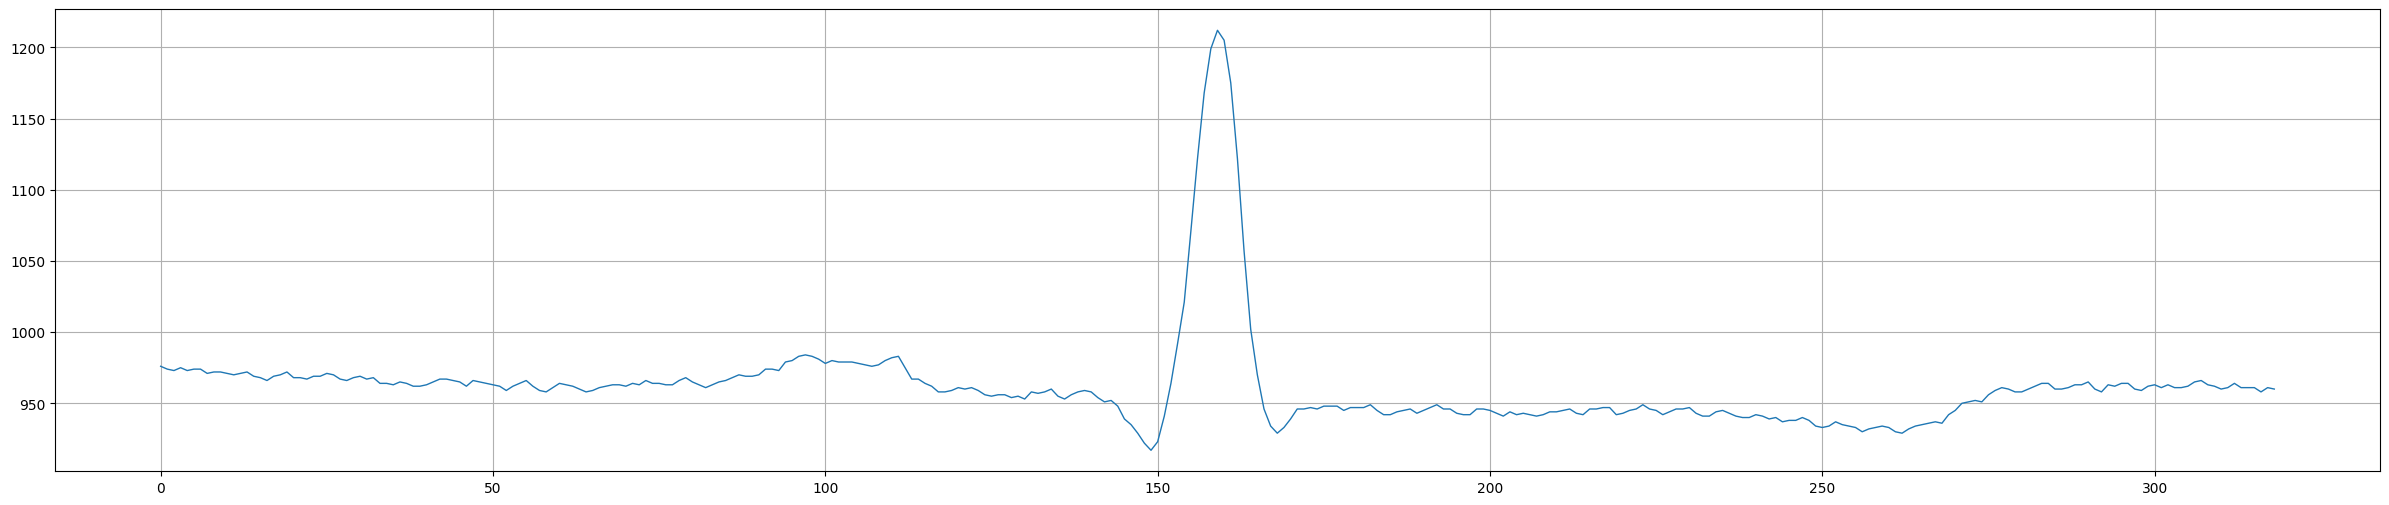

In [ ]:
plt.plot(X[0])
print(y[0])

In [ ]:
for i in range(0,len(X)):
        X[i].append(y[i])

print(np.shape(X))

(42021, 320)


319
0    9997
1    8071
2    7255
4    7129
5    7023
3    2546
Name: count, dtype: int64


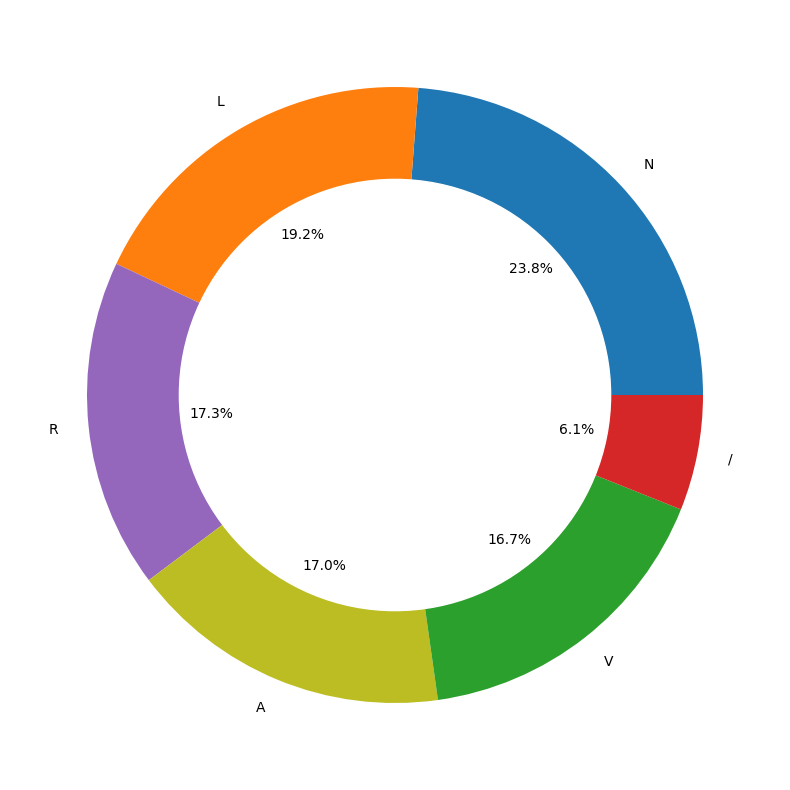

In [ ]:
# representation of classes % wise
import pandas as pd

X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V', '/'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green','tab:red'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [ ]:
# plot_percentage()
from sklearn.utils import resample

df_1=X_train_df[X_train_df[319]==1]
df_2=X_train_df[X_train_df[319]==2]
df_3=X_train_df[X_train_df[319]==3]
df_4=X_train_df[X_train_df[319]==4]
df_5=X_train_df[X_train_df[319]==5]
df_0=(X_train_df[X_train_df[319]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])

319
0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
Name: count, dtype: int64


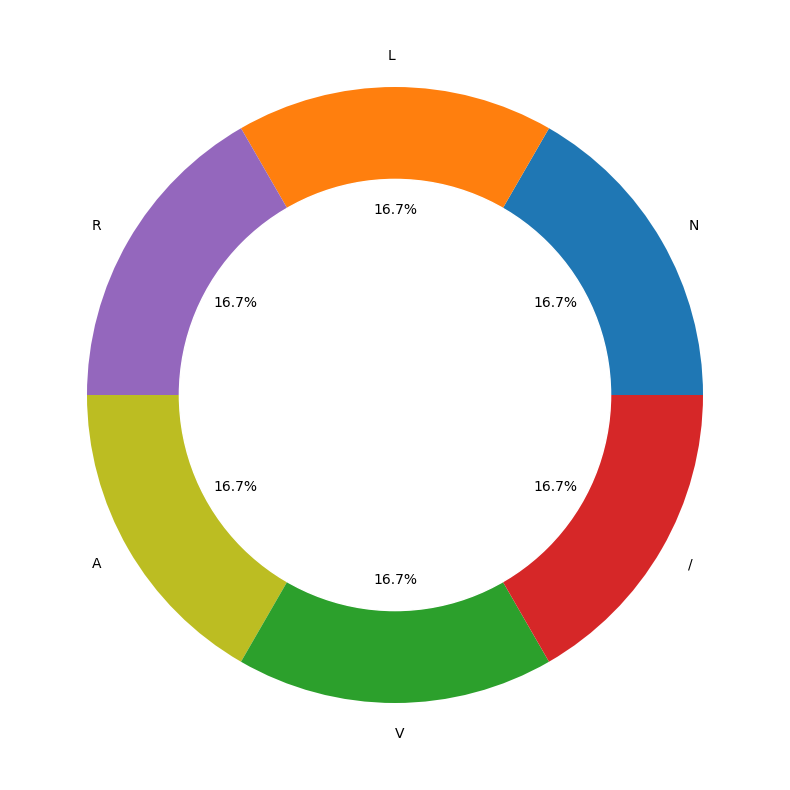

In [ ]:
per_class = X_train_df[319].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V', '/'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green','tab:red'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [ ]:
# Train Test Split
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", len(train))
print("X_test  : ", len(test))

X_train :  24000
X_test  :  6000


In [ ]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
print(np.shape(y_train), np.shape(y_test))

(24000, 6) (6000, 6)


In [ ]:
X_train = train.iloc[:,:train.shape[1]-1].values
X_test = test.iloc[:,:test.shape[1]-1].values
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
print(np.shape(X_train))

(24000, 319, 1)


In [ ]:
# from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, concatenate, MaxPool2D, ELU
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling2D,BatchNormalization
# from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint



In [ ]:
X_train.shape[1]

319

In [ ]:
from keras.layers import Layer
import tensorflow as tf
import numpy as np

class SineCosineLayer(Layer):
    def __init__(self, output_dim, alpha=1, beta=1, **kwargs):
        self.output_dim = output_dim
        self.alpha = alpha
        self.beta = beta
        super(SineCosineLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(int(input_shape[-1]), self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(SineCosineLayer, self).build(input_shape)

    def call(self, x):
        # Sine Cosine Algorithm
        W = self.kernel

        # Sine component
        sin_output = tf.math.sin(tf.matmul(x, W) * self.alpha)

        # Cosine component
        cos_output = tf.math.cos(tf.matmul(x, W) * self.beta)

        # Concatenate sine and cosine outputs
        output = tf.concat([sin_output, cos_output], axis=-1)

        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim * 2)

In [ ]:
from keras.applications import DenseNet121
from keras.optimizers import Adam
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def network(X_train, y_train, X_test, y_test):
    num_timesteps = X_train.shape[1]

    inputs_cnn = Input(shape=(num_timesteps, 1), name='inputs_cnn')

    # 1D CNN layers
    conv1 = Conv1D(64, kernel_size=3, activation='relu')(inputs_cnn)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    conv2 = Conv1D(128, kernel_size=3, activation='relu')(pool1)
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    conv3 = Conv1D(256, kernel_size=3, activation='relu')(pool2)
    pool3 = MaxPooling1D(pool_size=2)(conv3)

    conv4 = Conv1D(64, kernel_size=3, activation='relu')(pool3)
    pool4 = MaxPooling1D(pool_size=2)(conv4)

    conv5 = Conv1D(128, kernel_size=3, activation='relu')(pool4)
    pool5 = MaxPooling1D(pool_size=2)(conv5)

    conv6 = Conv1D(256, kernel_size=3, activation='relu')(pool5)
    pool6 = MaxPooling1D(pool_size=2)(conv6)

    #conv7 = Conv1D(512, kernel_size=3, activation='relu')(pool6)
    #pool7 = MaxPooling1D(pool_size=2)(conv7)
    # Flatten the output
    flatten = Flatten()(pool6)

    # Apply SCA layer
    sca_output = SineCosineLayer(output_dim=1024)(flatten)

    # Dense layers
    dense_end1 = Dense(1024, activation='relu')(sca_output)

    # Output layer
    main_output = Dense(6, activation='softmax', name='main_output')(dense_end1)

    model = Model(inputs=inputs_cnn, outputs=main_output)

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
                 ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history = model.fit(X_train, y_train, epochs=10, callbacks=callbacks, batch_size=32, validation_data=(X_test, y_test))
    model.load_weights('best_model.h5')

    # Evaluate the model on the test set
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1] * 100))

    # Predictions
    prediction_proba = model.predict(X_test)
    predictions = np.argmax(prediction_proba, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Compute precision, recall, and F1-score
    precision = precision_score(y_true, predictions, average='weighted')
    recall = recall_score(y_true, predictions, average='weighted')
    f1 = f1_score(y_true, predictions, average='weighted')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, predictions)
    plot_confusion_matrix(cm, classes=['0', '1', '2', '3', '4', '5'], title='')

    return model, history


In [ ]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))

    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4','5']

    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

Epoch 1/10
750/750 [==============================] - 129s 169ms/step - loss: 0.8009 - accuracy: 0.7183 - val_loss: 0.1457 - val_accuracy: 0.9550
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


750/750 [==============================] - 128s 171ms/step - loss: 0.1520 - accuracy: 0.9525 - val_loss: 0.1094 - val_accuracy: 0.9673
Epoch 3/10
750/750 [==============================] - 125s 167ms/step - loss: 0.1073 - accuracy: 0.9654 - val_loss: 0.0752 - val_accuracy: 0.9743
Epoch 4/10
750/750 [==============================] - 126s 168ms/step - loss: 0.1211 - accuracy: 0.9625 - val_loss: 0.0895 - val_accuracy: 0.9770
Epoch 5/10
750/750 [==============================] - 127s 170ms/step - loss: 0.0903 - accuracy: 0.9712 - val_loss: 0.0565 - val_accuracy: 0.9807
Epoch 6/10
750/750 [==============================] - 131s 175ms/step - loss: 0.0881 - accuracy: 0.9720 - val_loss: 0.0648 - val_accuracy: 0.9788
Epoch 7/10
750/750 [==============================] - 142s 190ms/step - loss: 0.0920 - accuracy: 0.9730 - val_loss: 0.0848 - val_accuracy: 0.9717
Epoch 8/10
750/750 [==============================] - 132s 176ms/step - loss: 0.0726 - accuracy: 0.9784 - val_loss: 0.0969 - val_accura

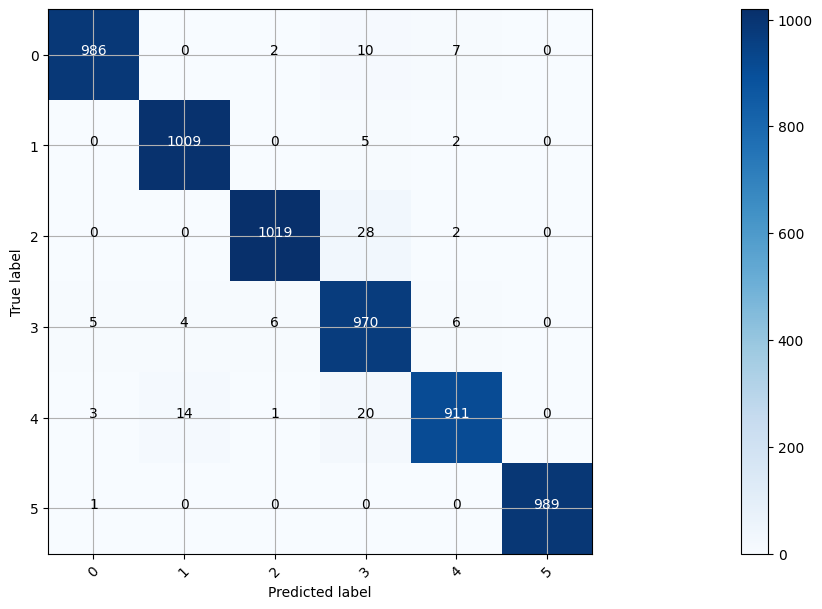

In [ ]:
model, history = network(X_train, y_train, X_test, y_test)

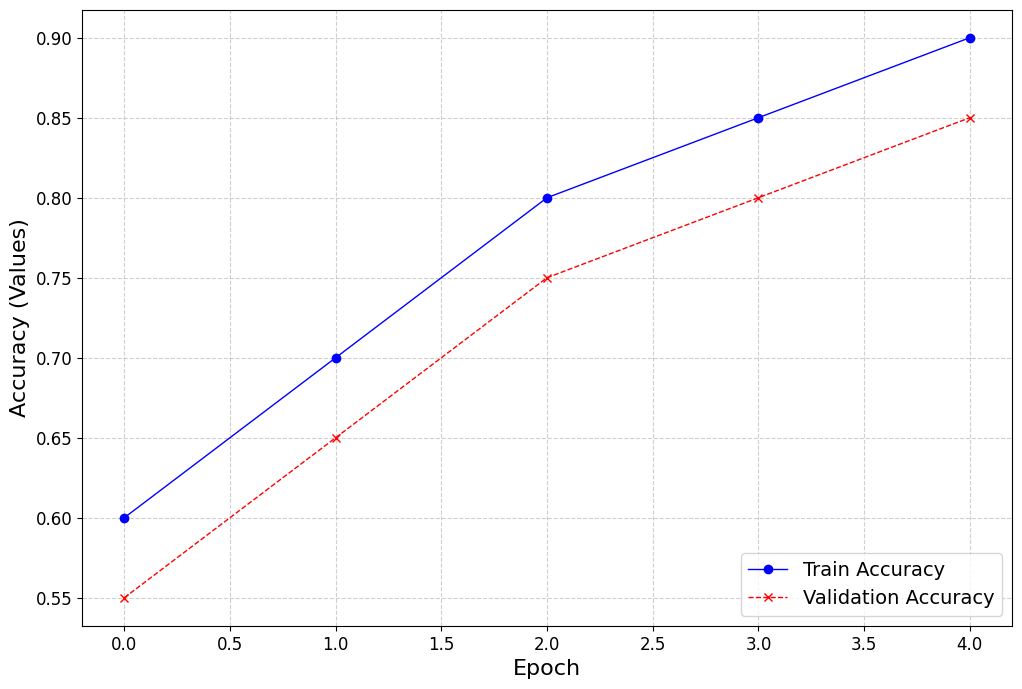

In [ ]:
import matplotlib.pyplot as plt

# Example training history data
history = {
    'accuracy': [0.6, 0.7, 0.8, 0.85, 0.9],
    'val_accuracy': [0.55, 0.65, 0.75, 0.8, 0.85]
}

# Create a figure with specified size
plt.figure(figsize=(12, 8))

# Plot training accuracy
plt.plot(history['accuracy'], marker='o', linestyle='-', color='b', label='Train Accuracy')

# Plot validation accuracy
plt.plot(history['val_accuracy'], marker='x', linestyle='--', color='r', label='Validation Accuracy')

# Customize the title and labels with larger font sizes
plt.title('', fontsize=20, fontweight='bold')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy (Values)', fontsize=16)

# Customize ticks on the axes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Add a legend with larger font size and a more suitable location
plt.legend(loc='lower right', fontsize=14)

# Display the plot
plt.show()


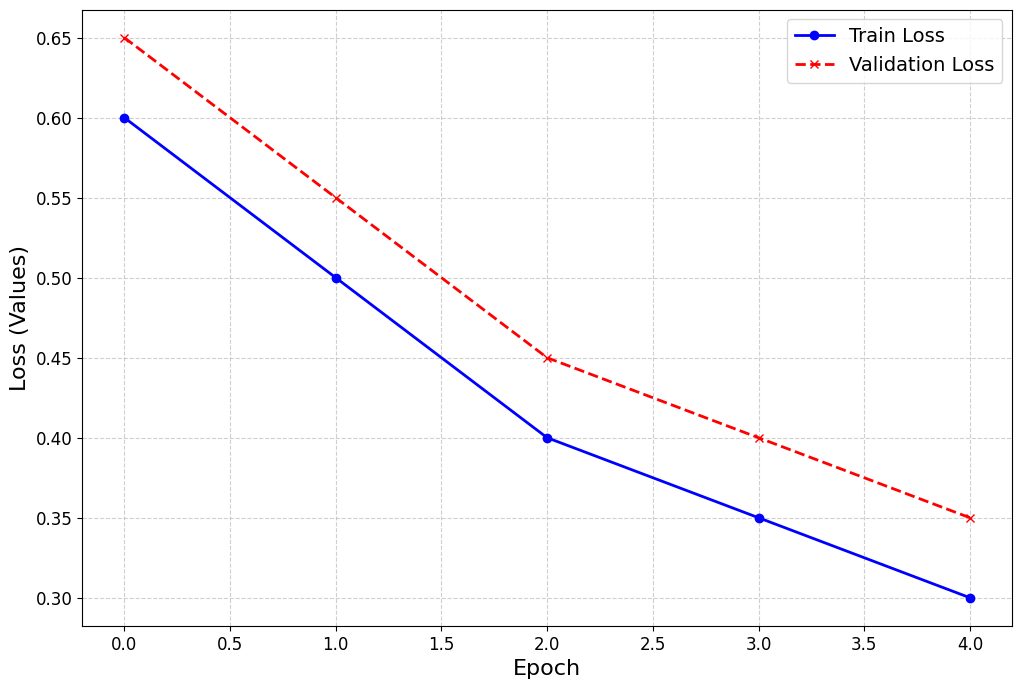

In [ ]:
import matplotlib.pyplot as plt

# Example training history data for demonstration purposes
history = {
    'loss': [0.6, 0.5, 0.4, 0.35, 0.3],
    'val_loss': [0.65, 0.55, 0.45, 0.4, 0.35]
}

# Create a figure with specified size
plt.figure(figsize=(12, 8))

# Plot training loss
plt.plot(history['loss'], marker='o', linestyle='-', color='b', label='Train Loss', linewidth=2)

# Plot validation loss
plt.plot(history['val_loss'], marker='x', linestyle='--', color='r', label='Validation Loss', linewidth=2)

# Customize the title and labels with larger font sizes
plt.title('', fontsize=20, fontweight='bold')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss (Values)', fontsize=16)

# Customize ticks on the axes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Add a legend with larger font size and a more suitable location
plt.legend(loc='upper right', fontsize=14)

# Display the plot
plt.show()


In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)

# Extract accuracy from scores
overall_accuracy = scores[1]

print(f'Overall Accuracy: {overall_accuracy * 100:.2f}%')

Overall Accuracy: 98.07%


In [ ]:
# Evaluate the model on the test set
scores = model.evaluate(X_test, y_test, verbose=0)

# Extract loss from scores
overall_loss = scores[0]

print(f'Overall Loss: {overall_loss:.4f}')

Overall Loss: 0.0565


In [ ]:
pip install matplotlib


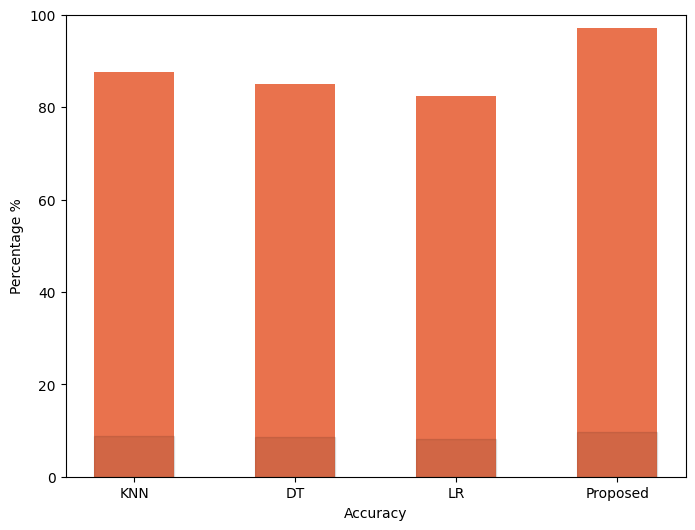

In [ ]:
import matplotlib.pyplot as plt


products = ['KNN', 'DT', 'LR', 'Proposed']
sales = [87.5, 84.9, 82.3, 97.23]


plt.figure(figsize=(8, 6))


bars = plt.bar(products, sales, color='#e9724d', width=0.5)


for bar in bars:

    x = bar.get_x()
    y = 0
    width = bar.get_width()
    height = 0.1 * bar.get_height()


    shade_rect = plt.Rectangle((x, y), width, height, color='black', alpha=0.1)
    plt.gca().add_patch(shade_rect)


plt.title('')
plt.xlabel('Accuracy')
plt.ylabel('Percentage %')


plt.ylim(0, 100)


plt.grid(False)


plt.show()


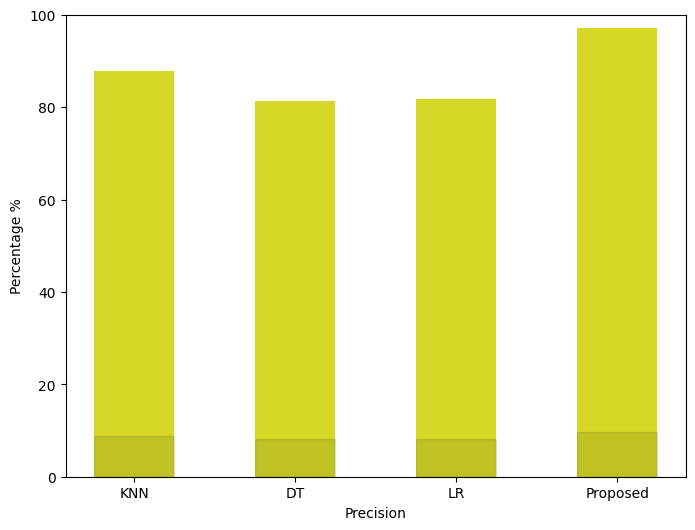

In [ ]:
import matplotlib.pyplot as plt


products = ['KNN', 'DT', 'LR', 'Proposed']
sales = [87.8, 81.3, 81.8, 97.2]


plt.figure(figsize=(8, 6))


bars = plt.bar(products, sales, color='#d6d727', width=0.5)


for bar in bars:

    x = bar.get_x()
    y = 0
    width = bar.get_width()
    height = 0.1 * bar.get_height()


    shade_rect = plt.Rectangle((x, y), width, height, color='black', alpha=0.1)
    plt.gca().add_patch(shade_rect)


plt.title('')
plt.xlabel('Precision')
plt.ylabel('Percentage %')


plt.ylim(0, 100)


plt.grid(False)


plt.show()


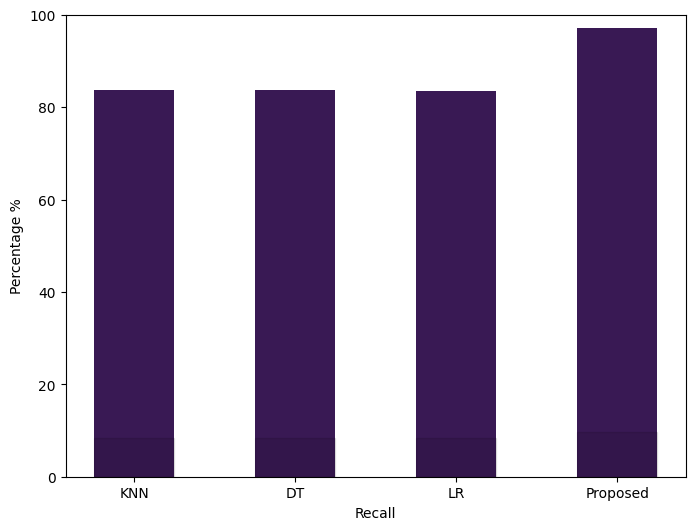

In [ ]:
import matplotlib.pyplot as plt


products = ['KNN', 'DT', 'LR', 'Proposed']
sales = [83.8, 83.8, 83.5, 97.2]


plt.figure(figsize=(8, 6))


bars = plt.bar(products, sales, color='#391954', width=0.5)


for bar in bars:

    x = bar.get_x()
    y = 0
    width = bar.get_width()
    height = 0.1 * bar.get_height()


    shade_rect = plt.Rectangle((x, y), width, height, color='black', alpha=0.1)
    plt.gca().add_patch(shade_rect)


plt.title('')
plt.xlabel('Recall')
plt.ylabel('Percentage %')


plt.ylim(0, 100)


plt.grid(False)


plt.show()


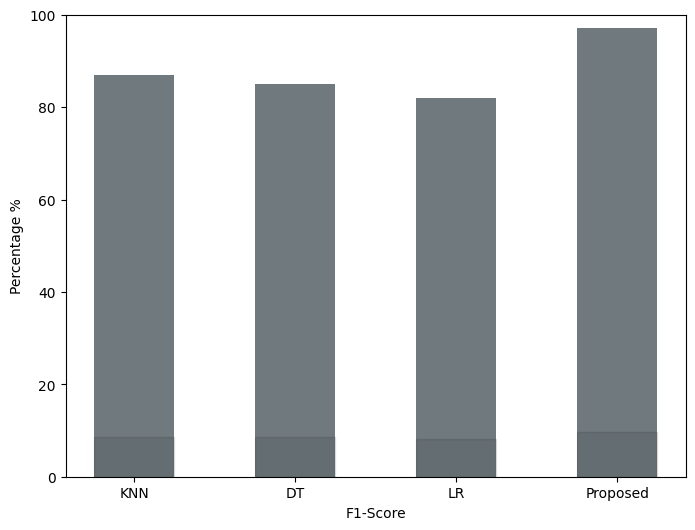

In [ ]:
import matplotlib.pyplot as plt


products = ['KNN', 'DT', 'LR', 'Proposed']
sales = [87, 85, 82, 97.2]


plt.figure(figsize=(8, 6))


bars = plt.bar(products, sales, color='#707a7e', width=0.5)


for bar in bars:

    x = bar.get_x()
    y = 0
    width = bar.get_width()
    height = 0.1 * bar.get_height()


    shade_rect = plt.Rectangle((x, y), width, height, color='black', alpha=0.1)
    plt.gca().add_patch(shade_rect)


plt.title('')
plt.xlabel('F1-Score')
plt.ylabel('Percentage %')


plt.ylim(0, 100)


plt.grid(False)


plt.show()


<ipython-input-27-eccc8aa136fd>:42: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(False, linestyle='--', alpha=0.7)


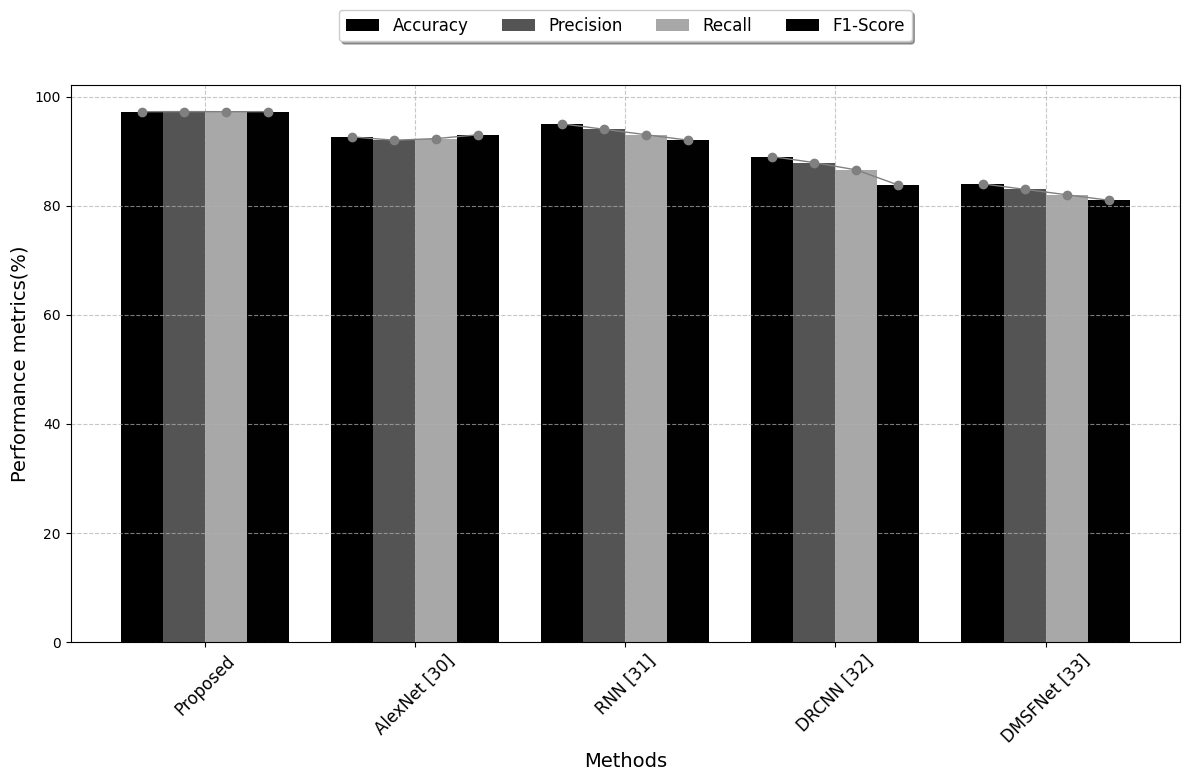

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Models
models = ['Proposed', 'AlexNet [30]', 'RNN [31]', 'DRCNN [32]', 'DMSFNet [33]']

# Performance metrics
accuracy = [97.23, 92.61, 95.00, 88.99, 84.00]
precision = [97.25, 92.00, 94.00, 87.89, 83.00]
recall = [97.23, 92.30, 93.00, 86.55, 82.00]
f1_score = [97.24, 93.00, 92.00, 83.77, 81.00]

# Plotting
x = range(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 8))

# Create a linear gradient colormap
colors = [(0, '#000000'), (0.5, '#808080'), (1, '#ffffff')]
cmap = LinearSegmentedColormap.from_list('custom', colors)

bar1 = ax.bar(x, accuracy, width, label='Accuracy', color=cmap(0))
bar2 = ax.bar([i + width for i in x], precision, width, label='Precision', color=cmap(0.33))
bar3 = ax.bar([i + 2 * width for i in x], recall, width, label='Recall', color=cmap(0.66))
bar4 = ax.bar([i + 3 * width for i in x], f1_score, width, label='F1-Score', color=cmap(1))

# Annotate the bars with lines with gradient color
for i in x:
    ax.plot([i, i + width, i + 2 * width, i + 3 * width], [accuracy[i], precision[i], recall[i], f1_score[i]], marker='o', color='gray', linestyle='-', linewidth=1)

ax.set_xlabel('Methods', fontsize=14)
ax.set_ylabel('Performance metrics(%)', fontsize=14)
ax.set_title('', fontsize=16)
ax.set_xticks([i + 1.5 * width for i in x])
ax.set_xticklabels(models, fontsize=12)

# Move legend to top and center
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True, ncol=4, fontsize=12)

# Add grid lines
ax.grid(True, linestyle='--', alpha=0.7)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


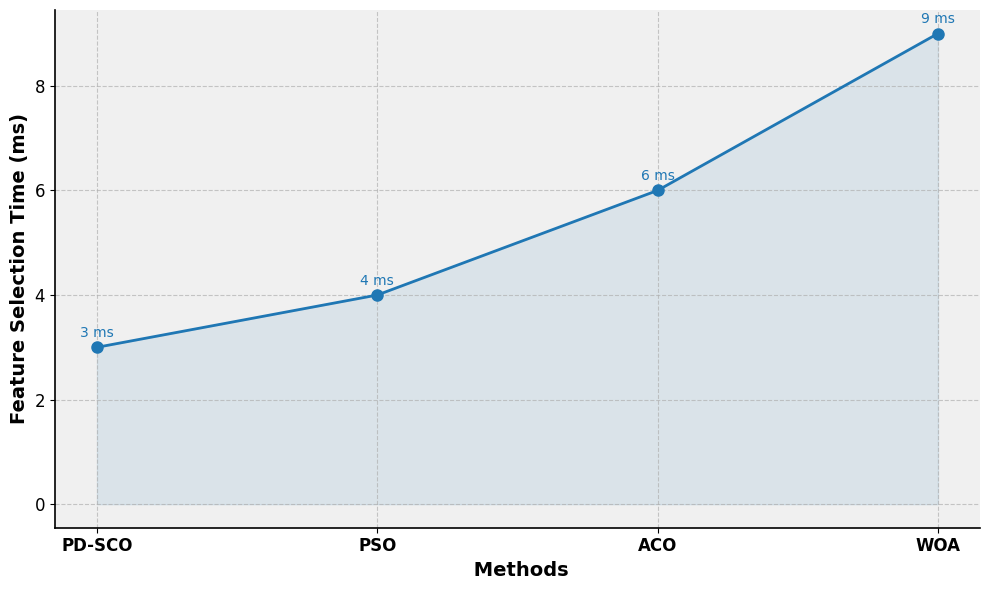

In [ ]:
import matplotlib.pyplot as plt

# Feature selection methods and their times in milliseconds
methods = ['PD-SCO', 'PSO', 'ACO', 'WOA']
times = [3, 4, 6, 9]

# Plotting the line graph
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(methods, times, marker='o', linestyle='-', color='#1f77b4', linewidth=2, markersize=8)

# Shading the area under the line
ax.fill_between(methods, times, color='#1f77b4', alpha=0.1)

# Annotating the points
for i, time in enumerate(times):
    ax.text(i, time + 0.2, f'{time} ms', ha='center', fontsize=10, color='#1f77b4')

# Setting the labels and title
ax.set_xlabel(' Methods', fontsize=14, fontweight='bold')
ax.set_ylabel('Feature Selection Time (ms)', fontsize=14, fontweight='bold')
ax.set_title('', fontsize=16, fontweight='bold')

# Customizing ticks
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, fontsize=12, fontweight='bold')

# Adding grid lines
ax.grid(True, linestyle='--', alpha=0.7)

# Adding background color and borders
ax.set_facecolor('#f0f0f0')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

plt.tight_layout()
plt.show()


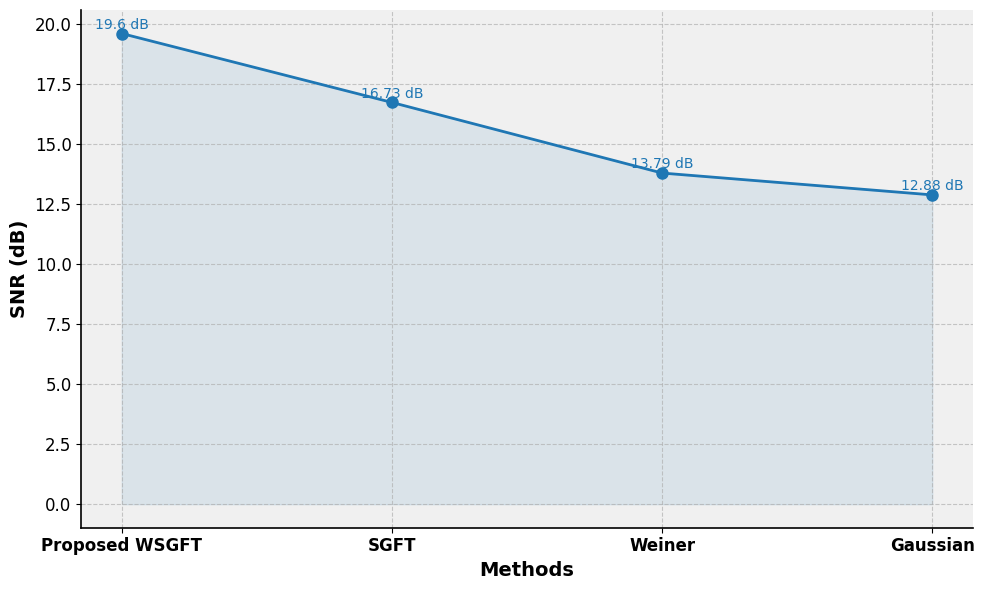

In [ ]:
import matplotlib.pyplot as plt

# SNR (dB) values for different methods
methods = ['Proposed WSGFT', 'SGFT', 'Weiner', 'Gaussian']
snr_values = [19.6, 16.73, 13.79, 12.88]

# Plotting the line graph
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(methods, snr_values, marker='o', linestyle='-', color='#1f77b4', linewidth=2, markersize=8)

# Shading the area under the line
ax.fill_between(methods, snr_values, color='#1f77b4', alpha=0.1)

# Annotating the points
for i, snr in enumerate(snr_values):
    ax.text(i, snr + 0.2, f'{snr} dB', ha='center', fontsize=10, color='#1f77b4')

# Setting the labels and title
ax.set_xlabel('Methods', fontsize=14, fontweight='bold')
ax.set_ylabel('SNR (dB)', fontsize=14, fontweight='bold')
ax.set_title('', fontsize=16, fontweight='bold')

# Customizing ticks
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, fontsize=12, fontweight='bold')

# Adding grid lines
ax.grid(True, linestyle='--', alpha=0.7)

# Adding background color and borders
ax.set_facecolor('#f0f0f0')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

plt.tight_layout()
plt.show()


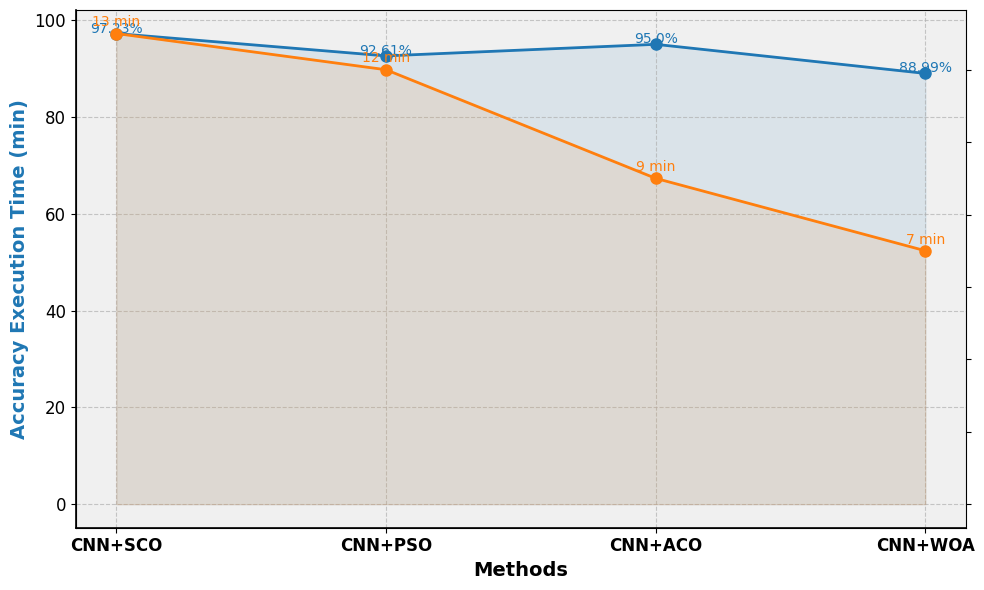

In [ ]:
import matplotlib.pyplot as plt

# Data for the new graph
methods = ['CNN+SCO', 'CNN+PSO', 'CNN+ACO', 'CNN+WOA']
accuracy = [97.23, 92.61, 95.00, 88.99]
execution_time = [13, 12, 9, 7]

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the Accuracy line graph
ax1.plot(methods, accuracy, marker='o', linestyle='-', color='#1f77b4', linewidth=2, markersize=8, label='Accuracy')
ax1.fill_between(methods, accuracy, color='#1f77b4', alpha=0.1)

# Annotating the points for Accuracy
for i, acc in enumerate(accuracy):
    ax1.text(i, acc + 0.2, f'{acc}%', ha='center', fontsize=10, color='#1f77b4')

# Setting the labels for Accuracy
ax1.set_xlabel('Methods', fontsize=14, fontweight='bold')
ax1.set_ylabel('Values', fontsize=14, fontweight='bold', color='#1f77b4')

# Creating a second y-axis for Execution Time
ax2 = ax1.twinx()
ax2.plot(methods, execution_time, marker='o', linestyle='-', color='#ff7f0e', linewidth=2, markersize=8, label='Execution Time')
ax2.fill_between(methods, execution_time, color='#ff7f0e', alpha=0.1)

# Annotating the points for Execution Time
for i, time in enumerate(execution_time):
    ax2.text(i, time + 0.2, f'{time} min', ha='center', fontsize=10, color='#ff7f0e')

# Remove the right side y-axis values
ax2.set_yticklabels([])

# Setting the labels for Execution Time
ax2.set_ylabel('', fontsize=14, fontweight='bold', color='#ff7f0e')

# Adding grid lines
ax1.grid(True, linestyle='--', alpha=0.7)

# Customizing ticks
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xticks(range(len(methods)))
ax1.set_xticklabels(methods, fontsize=12, fontweight='bold')

# Adding background color and borders
ax1.set_facecolor('#f0f0f0')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_linewidth(1.2)
ax1.spines['bottom'].set_linewidth(1.2)

plt.tight_layout()
plt.show()


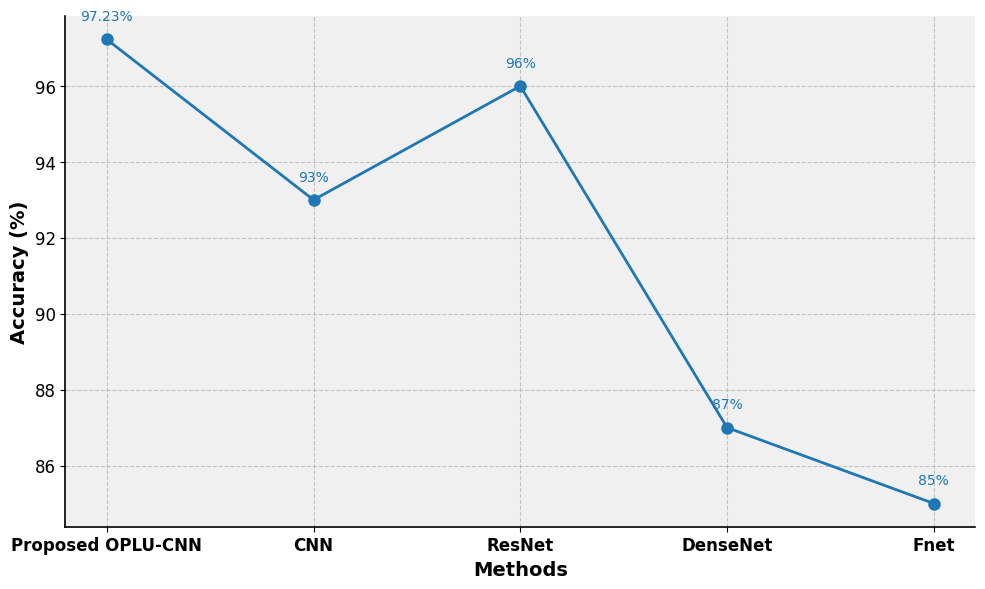

In [ ]:
import matplotlib.pyplot as plt

# Data for the graph
methods = ['Proposed OPLU-CNN', 'CNN', 'ResNet', 'DenseNet', 'Fnet']
accuracy = [97.23, 93, 96, 87, 85]

# Plotting the line graph
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(methods, accuracy, marker='o', linestyle='-', color='#1f77b4', linewidth=2, markersize=8)

# Annotating the points
for i, acc in enumerate(accuracy):
    ax.text(i, acc + 0.5, f'{acc}%', ha='center', fontsize=10, color='#1f77b4')

# Setting the labels and title
ax.set_xlabel('Methods', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax.set_title('', fontsize=16, fontweight='bold')

# Customizing ticks
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, fontsize=12, fontweight='bold')

# Adding grid lines
ax.grid(True, linestyle='--', alpha=0.7)

# Adding background color and borders
ax.set_facecolor('#f0f0f0')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

plt.tight_layout()
plt.show()


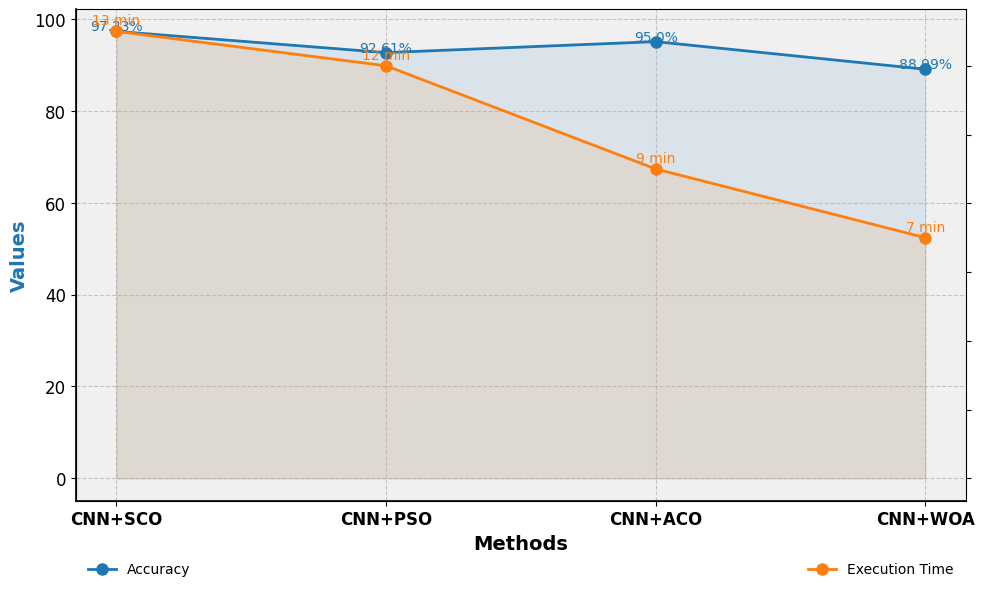

In [ ]:
import matplotlib.pyplot as plt

# Data for the new graph
methods = ['CNN+SCO', 'CNN+PSO', 'CNN+ACO', 'CNN+WOA']
accuracy = [97.23, 92.61, 95.00, 88.99]
execution_time = [13, 12, 9, 7]

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the Accuracy line graph
ax1.plot(methods, accuracy, marker='o', linestyle='-', color='#1f77b4', linewidth=2, markersize=8, label='Accuracy')
ax1.fill_between(methods, accuracy, color='#1f77b4', alpha=0.1)

# Annotating the points for Accuracy
for i, acc in enumerate(accuracy):
    ax1.text(i, acc + 0.2, f'{acc}%', ha='center', fontsize=10, color='#1f77b4')

# Setting the labels for Accuracy
ax1.set_xlabel('Methods', fontsize=14, fontweight='bold')
ax1.set_ylabel('Values', fontsize=14, fontweight='bold', color='#1f77b4')

# Creating a second y-axis for Execution Time
ax2 = ax1.twinx()
ax2.plot(methods, execution_time, marker='o', linestyle='-', color='#ff7f0e', linewidth=2, markersize=8, label='Execution Time')
ax2.fill_between(methods, execution_time, color='#ff7f0e', alpha=0.1)

# Annotating the points for Execution Time
for i, time in enumerate(execution_time):
    ax2.text(i, time + 0.2, f'{time} min', ha='center', fontsize=10, color='#ff7f0e')

# Remove the right side y-axis values
ax2.set_yticklabels([])

# Setting the labels for Execution Time
ax2.set_ylabel('', fontsize=14, fontweight='bold', color='#ff7f0e')

# Adding legends
ax1_legend = ax1.legend(loc='upper left', fontsize=10, bbox_to_anchor=(0, -0.1), frameon=False)
ax2_legend = ax2.legend(loc='upper right', fontsize=10, bbox_to_anchor=(1, -0.1), frameon=False)

# Adding grid lines
ax1.grid(True, linestyle='--', alpha=0.7)

# Customizing ticks
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xticks(range(len(methods)))
ax1.set_xticklabels(methods, fontsize=12, fontweight='bold')

# Adding background color and borders
ax1.set_facecolor('#f0f0f0')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_linewidth(1.2)
ax1.spines['bottom'].set_linewidth(1.2)

plt.tight_layout()
plt.show()
